<a href="https://colab.research.google.com/github/veritaem/DS-Sprint-01-Dealing-With-Data/blob/master/module1-afirstlookatdata/LS_DS_111_A_First_Look_at_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - A First Look at Data



## Lecture - let's explore Python DS libraries and examples!

The Python Data Science ecosystem is huge. You've seen some of the big pieces - pandas, scikit-learn, matplotlib. What parts do you want to see more of?

In [53]:
# TODO - we'll be doing this live, taking requests
# and reproducing what it is to look up and learn things
1+1

2

## Assignment - now it's your turn

Pick at least one Python DS library, and using documentation/examples reproduce in this notebook something cool. It's OK if you don't fully understand it or get it 100% working, but do put in effort and look things up.

In [3]:
##http://nbviewer.jupyter.org/github/vincentarelbundock/Reinhart-Rogoff/blob/master/reinhart-rogoff.ipynb
##this is the notebook i used

# TODO - your code here
# Use what we did live in lecture as an example
import statsmodels.api as sm
import patsy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

RR = pd.read_csv('https://gist.githubusercontent.com/vincentarelbundock/5409893/raw/a623f2f3bae027a0e51dd01ac5b70d44d909a7b9/RR-processed.csv')
##i couldnt make it read the csv posted in the notebook code so I got the raw and used it

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
RR.groupby('Country').size()

Country
Australia      64
Austria        62
Belgium        63
Canada         64
Denmark        56
Finland        64
France         54
Germany        59
Greece         40
Ireland        63
Italy          59
Japan          54
Netherlands    53
New Zealand    64
Norway         64
Portugal       58
Spain          42
Sweden         64
UK             64
US             64
dtype: int64

In [0]:
bins = ["0-30%","30-60%","60-90%","Above 90%"]
RR['dgcat'] = np.digitize(RR.debtgdp, [0,30,60,90,np.inf]) - 1
RR.dgcat = [bins[x] for x in RR.dgcat]

bins = ["0-30%","30-60%","60-90%","90-120%","Above 120%"]
RR['dgcat2'] = np.digitize(RR.debtgdp, [0,30,60,90,120,np.inf]) - 1
RR.dgcat2 = [bins[x] for x in RR.dgcat2]

In [7]:
y2,X2 = patsy.dmatrices('dRGDP ~ dgcat2', data=RR[['dRGDP', 'dgcat2']].dropna())
print(sm.OLS(y2,X2).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                  dRGDP   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     14.24
Date:                Mon, 05 Nov 2018   Prob (F-statistic):           2.36e-11
Time:                        23:02:34   Log-Likelihood:                -2926.9
No. Observations:                1175   AIC:                             5864.
Df Residuals:                    1170   BIC:                             5889.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                4.1735 

In [8]:
RR.shape

(1175, 29)

In [9]:
RR.describe()
##they used several operations in the notebook to get some of this info so I figured
##this might be easier and more readable.

,Unnamed: 0,Year,Debt,RGDP,GDP,dRGDP,GDPI,GDP1,GDP2,RGDP1,...,Debtalt,GDP2alt,GDPalt,RGDP2alt,debtgdp,GDP3,GNI,lRGDP,lRGDP1,lRGDP2
count,1175.00000,1175.000000,8.220000e+02,2.070000e+02,1.280000e+02,1175.000000,93.000000,7.730000e+02,8.850000e+02,8.140000e+02,...,1.180000e+02,8.800000e+01,4.400000e+01,31.000000,1175.000000,30.000000,4.800000e+01,2.100000e+02,8.290000e+02,4.350000e+02
mean,588.00000,1979.254468,1.593857e+07,2.369173e+05,1.957611e+05,3.413757,50.341802,1.444103e+07,1.812497e+07,1.401169e+07,...,1.006665e+07,4.450790e+05,2.079659e+06,103333.064516,46.320173,76891.133333,5.156239e+08,2.351587e+05,1.382204e+07,3.047113e+07
std,339.33759,17.993206,9.113481e+07,3.229943e+05,3.693084e+05,2.992940,35.832360,6.444771e+07,8.181769e+07,6.658949e+07,...,2.569075e+07,5.716624e+05,1.951114e+06,23514.613796,32.346159,58596.977435,6.478610e+08,3.213443e+05,6.602166e+07,1.134847e+08
min,1.00000,1946.000000,7.300000e+00,1.776100e+03,2.222000e+02,-10.942159,3.560000,3.944800e+01,1.574600e+01,1.793000e+02,...,2.051000e+03,1.530500e+04,2.617545e+05,69620.000000,3.279110,13101.000000,1.074800e+07,1.776100e+03,1.668000e+02,2.433500e+02
25%,294.50000,1964.000000,6.493725e+03,1.006890e+04,2.227875e+03,1.904000,9.240000,1.941800e+04,1.507300e+04,3.398616e+04,...,6.343700e+04,5.541375e+04,5.148981e+05,85553.000000,22.199082,28952.500000,3.221400e+07,9.961600e+03,3.323500e+04,9.707600e+04
50%,588.00000,1980.000000,3.594450e+04,8.724400e+04,1.301700e+04,3.283427,51.630000,1.808000e+05,1.066650e+05,1.033649e+05,...,2.652500e+05,1.198715e+05,1.093388e+06,100822.000000,40.503248,50016.500000,1.299235e+08,8.706950e+04,1.021640e+05,4.295000e+05
75%,881.50000,1995.000000,2.858835e+05,3.543640e+05,1.525658e+05,5.099766,79.790000,1.740450e+06,6.957710e+05,4.413502e+05,...,3.123550e+06,8.130648e+05,3.399964e+06,118257.000000,61.473961,126926.250000,9.128128e+08,3.506410e+05,4.296940e+05,1.579190e+06
max,1175.00000,2009.000000,8.699630e+08,1.275299e+06,1.446110e+06,27.329193,113.140000,5.080005e+08,5.158050e+08,4.940320e+08,...,9.330700e+07,1.950085e+06,6.760830e+06,149616.000000,247.481942,189751.000000,2.047810e+09,1.275299e+06,4.940320e+08,5.605110e+08


In [0]:
RR.dRGDP = RR.dRGDP.fillna(method = 'ffill')
RR.Debt = RR.Debt.fillna(method = 'ffill')

In [11]:
##redid a regression model between debt and gdp                                               

X = RR["dRGDP"]
y = RR["Debt"]


model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Debt   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.685
Date:                Mon, 05 Nov 2018   Prob (F-statistic):              0.102
Time:                        23:02:41   Log-Likelihood:                -23008.
No. Observations:                1175   AIC:                         4.602e+04
Df Residuals:                    1174   BIC:                         4.602e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
dRGDP       8.139e+05   4.97e+05      1.639      0.102   -1.61e+05    1.79e+06
==============================================================================
Omnibus:                     1717.737   Durbin-Watson:                   0.116
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           332502.662
Skew:                           8.672   Prob(JB):                         0.00
Kurtosis:                      83.565   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

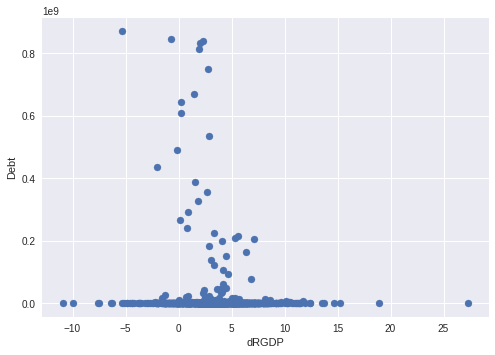

In [12]:
##using a scatter plot to visualize their data showing the relationship between GDP and Debt
plt.scatter(RR.dRGDP, RR.Debt)
plt.xlabel('dRGDP')
plt.ylabel('Debt')
plt.show()

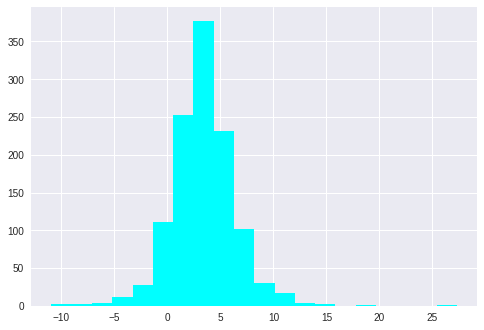

In [13]:
num_bins = 20
n, bins, patches = plt.hist(RR.dRGDP, num_bins, facecolor= 'cyan')
plt.show()
##I suspected GDP would be more or less a bell curve of some sort from the last chart, thats actually pretty interesting

In [19]:
years = range(1950, 2000, 5)
f = lambda x: (x, RR[RR.Year >= x].dRGDP.groupby(RR[RR.Year >= x].dgcat).mean())
[f(x) for x in years]

[(1950, dgcat
  0-30%        4.135295
  30-60%       2.980839
  60-90%       3.100982
  Above 90%    2.121852
  Name: dRGDP, dtype: float64), (1955, dgcat
  0-30%        4.014896
  30-60%       2.936220
  60-90%       2.883521
  Above 90%    2.077457
  Name: dRGDP, dtype: float64), (1960, dgcat
  0-30%        3.895619
  30-60%       2.909601
  60-90%       2.779663
  Above 90%    2.074064
  Name: dRGDP, dtype: float64), (1965, dgcat
  0-30%        3.537024
  30-60%       2.785822
  60-90%       2.635279
  Above 90%    1.959229
  Name: dRGDP, dtype: float64), (1970, dgcat
  0-30%        3.145224
  30-60%       2.644951
  60-90%       2.559289
  Above 90%    1.959229
  Name: dRGDP, dtype: float64), (1975, dgcat
  0-30%        2.642107
  30-60%       2.494691
  60-90%       2.546897
  Above 90%    1.959229
  Name: dRGDP, dtype: float64), (1980, dgcat
  0-30%        2.541408
  30-60%       2.451346
  60-90%       2.435681
  Above 90%    1.959229
  Name: dRGDP, dtype: float64), (1985, dgcat

In [0]:
import seaborn as sns

In [0]:
from sklearn import linear_model

Figure(576x396)


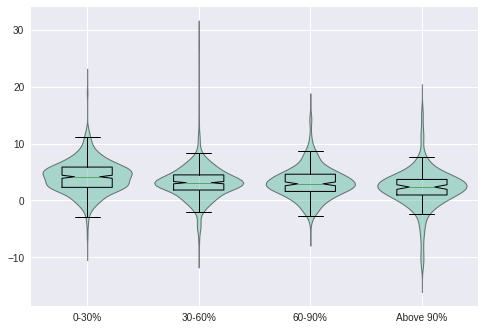

In [16]:
labels = ["0-30%","30-60%","60-90%","Above 90%"]
dat = [np.array(RR.dRGDP[RR.dgcat==x]) for x in labels]
print(sm.graphics.violinplot(dat, labels=labels))

Figure(576x396)


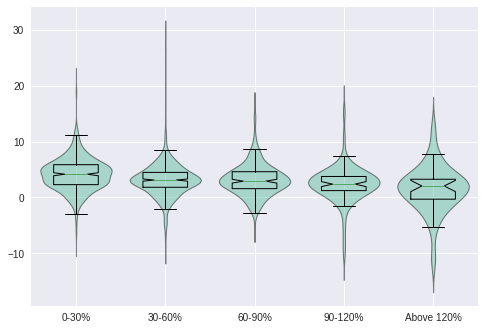

In [18]:
labels = ["0-30%","30-60%","60-90%","90-120%","Above 120%"]
dat = [np.array(RR.dRGDP[RR.dgcat2==x]) for x in labels]
print(sm.graphics.violinplot(dat, labels=labels))

In [63]:
RR.Country.groupby([RR.Country, RR.dRGDP]).size().unstack().sum() #ah so this is why the chart is flat

dRGDP
-10.942159    1.0
-9.922099     1.0
-7.635102     1.0
-7.500000     1.0
-6.355948     1.0
-6.243667     1.0
-5.369365     1.0
-5.296834     1.0
-5.145000     1.0
-4.871261     1.0
-4.827783     1.0
-4.565103     1.0
-4.400000     1.0
-4.347962     1.0
-4.172716     1.0
-3.824000     1.0
-3.767233     1.0
-3.735508     1.0
-3.638359     1.0
-3.557951     1.0
-3.182360     1.0
-3.000000     1.0
-2.896702     1.0
-2.730170     1.0
-2.458310     1.0
-2.433023     1.0
-2.259000     1.0
-2.175000     1.0
-2.146417     1.0
-2.081798     1.0
             ... 
 9.400000     1.0
 9.600000     1.0
 9.630896     1.0
 9.701776     1.0
 9.997697     1.0
 10.133700    1.0
 10.201270    1.0
 10.219665    1.0
 10.324798    1.0
 10.464422    1.0
 10.527807    1.0
 10.700000    1.0
 10.787437    1.0
 11.003754    1.0
 11.053114    1.0
 11.201347    1.0
 11.262118    1.0
 11.399403    1.0
 11.440554    1.0
 11.500000    1.0
 11.783224    1.0
 11.932079    1.0
 12.408962    1.0
 12.443586    1.0
 13.

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  Describe in a paragraph of text what you did and why, as if you were writing an email to somebody interested but nontechnical.

2.  What was the most challenging part of what you did?

3.  What was the most interesting thing you learned?

4.  What area would you like to explore with more time?




In [0]:
##because this paper was done in python 2 and seemed to be a bit more spread out
##and hard to read, i tried to use operations that made the data a bit clearer to read.

##definitely figuring out which columns are what.  The variable names for this are not super explanatory for many of them, and there are over 1000
##features so that definitely takes some getting used to, but i still got some cool
##info out of it, i suppoise with time we will find ways to dig into it mpore efficently

##I learned that you can use these OLS models to visulaize the numbers and use them together
##with charts to make the data much more readable, while still being intuitive

##I would definitely like to do more to see how to read into these kind of variables to determine which ones i want to spend time on

## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub (and since this is the first assignment of the sprint, open a PR as well).

- [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/)
- [scikit-learn documentation](http://scikit-learn.org/stable/documentation.html)
- [matplotlib documentation](https://matplotlib.org/contents.html)
- [Awesome Data Science](https://github.com/bulutyazilim/awesome-datascience) - a list of many types of DS resources

Stretch goals:

- Find and read blogs, walkthroughs, and other examples of people working through cool things with data science - and share with your classmates!
- Write a blog post (Medium is a popular place to publish) introducing yourself as somebody learning data science, and talking about what you've learned already and what you're excited to learn more about

In [0]:
https://medium.com/@dcharris776/first-day-55345e3f8249